# Data Analysis of Udacity Student Engagements

This data analysis was homework from [Udacity's Intro to Data Analysis](https://www.udacity.com/course/intro-to-data-analysis--ud170) course. The focus will be on the general data analysis process and using pure python with few additional libraries. 

## 1 ) Loading Data

We will be working with three CSV files:
* 1) enrollments.csv
* 2) daily_engagement.csv
* 3) project_submissions.csv

In [1]:
# Import libraries  
import unicodecsv
from datetime import datetime as dt
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def read_csv(filename):
    with open(filename, 'rb') as f:                # rb = read file in binary mode for CSVs
        reader = unicodecsv.DictReader(f)
        return list(reader)

# Call read_csv 
enrollments = read_csv('enrollments.csv')
daily_engagement = read_csv('daily_engagement.csv')
project_submissions = read_csv('project_submissions.csv')   

## 2) Data Cleaning

Now that the data is loaded, we need to understand what we are working with. 

* 1) The "enrollments.csv" file contains data for a random subset of students who complete their first project and a random subset of students who do not.

* 2) The "daily_engagement.csv" file contains data about engagement within udacity nanodegree courses for each student in the enrollment table on each day they were enrolled. Includes a record even if there was no engagement that day. It includes engagement data from both the supporting courses for the nanodegree program, and the corresponding freely available courses with the same content.

* 3) The "project_submissions.csv" file contains data about submissions for projects for each student in the enrollment table.


In [85]:
# Check data was loaded correctly. Print out the first row of each table.
print "Enrollment:", enrollments[0]
print
print "Daily Engagement:", daily_engagement[0]
print
print "Project Submission:", project_submissions[0]

Enrollment: {u'status': u'canceled', u'is_udacity': u'True', u'is_canceled': u'True', u'join_date': u'2014-11-10', u'account_key': u'448', u'cancel_date': u'2015-01-14', u'days_to_cancel': u'65'}

Daily Engagement: {u'lessons_completed': u'0.0', u'num_courses_visited': u'1.0', u'total_minutes_visited': u'11.6793745', u'projects_completed': u'0.0', u'acct': u'0', u'utc_date': u'2015-01-09'}

Project Submission: {u'lesson_key': u'3176718735', u'processing_state': u'EVALUATED', u'account_key': u'256', u'assigned_rating': u'UNGRADED', u'completion_date': u'2015-01-16', u'creation_date': u'2015-01-14'}


#### Renaming Columns: account_key and acct

We have an "account_key" column in the enrollments and project_submissions tables, but an "acct" column in the daily_engagement table. Assuming these are all corresponding to the unique verification of a student's account, we can rename the column "acct" to "account_key". 


In [86]:
daily_engagement[3]

{u'acct': u'0',
 u'lessons_completed': u'0.0',
 u'num_courses_visited': u'1.0',
 u'projects_completed': u'0.0',
 u'total_minutes_visited': u'33.4892696667',
 u'utc_date': u'2015-01-12'}

In [87]:
for engagement_record in daily_engagement:
    engagement_record['account_key'] = engagement_record['acct']
    # Delete the old column 
    del[engagement_record['acct']]

# Check that column is renamed "account_key" instead of "acct" 
daily_engagement[0]

{'account_key': u'0',
 u'lessons_completed': u'0.0',
 u'num_courses_visited': u'1.0',
 u'projects_completed': u'0.0',
 u'total_minutes_visited': u'11.6793745',
 u'utc_date': u'2015-01-09'}

#### Converting Data Types 

From printing out the first row of each table, we see the read_me function automatically converted all the datatypes to strings. 

* Date Data Types: Create a parse_date function. The "cancel_date" data can be converted to a Python datetime object. If the string is empty, then the student has not cancelled yet. The "days_to_cancel" data can be an empty string. If the string is empty, it means the student has not cancelled yet. 
* The 'account_key' data is kept as a string of numbers since they are unique and we will not be working mathematically with them. 

In [115]:
# Strings to DateTime objects 
def parse_date(date):
    if date == '': 
        return None
    else:
        return dt.strptime(date, '%Y-%m-%d')
    
# Strings to Integers 
def parse_maybe_int(i):
    if i == '': 
        return None 
    else:
        return int(i)

In [89]:
# Cleaning enrollment table
for enrollment in enrollments:
    # The is_canceled and is_udacity columns should both be boolean outputs 
    enrollment['cancel_date'] = parse_date(enrollment['cancel_date'])
    enrollment['days_to_cancel'] = parse_maybe_int(enrollment['days_to_cancel'])
    enrollment['is_canceled'] = enrollment['is_canceled'] == 'True'
    enrollment['is_udacity'] = enrollment['is_udacity'] == 'True'
    enrollment['join_date'] = parse_date(enrollment['join_date'])
enrollments[0]

{u'account_key': u'448',
 u'cancel_date': datetime.datetime(2015, 1, 14, 0, 0),
 u'days_to_cancel': 65,
 u'is_canceled': True,
 u'is_udacity': True,
 u'join_date': datetime.datetime(2014, 11, 10, 0, 0),
 u'status': u'canceled'}

In [90]:
# Cleaning Daily Engagements table 
for engagement_record in daily_engagement:
    # On Udacity, lessons_completed, num_courses_visited, and projects_completed need to be an integer
    # i.e. a student can not complete 0.5 of a lesson 
    engagement_record['lessons_completed'] = int(float(engagement_record['lessons_completed']))
    engagement_record['num_courses_visited'] = int(float(engagement_record['num_courses_visited']))
    engagement_record['projects_completed'] = int(float(engagement_record['projects_completed']))
    engagement_record['total_minutes_visited'] = float(engagement_record['total_minutes_visited'])
    engagement_record['utc_date'] = parse_date(engagement_record['utc_date'])
daily_engagement[0]

{'account_key': u'0',
 u'lessons_completed': 0,
 u'num_courses_visited': 1,
 u'projects_completed': 0,
 u'total_minutes_visited': 11.6793745,
 u'utc_date': datetime.datetime(2015, 1, 9, 0, 0)}

In [91]:
# Cleaning the project_submissions table 
for submission in project_submissions:
    submission['completion_date'] = parse_date(submission['completion_date'])
    submission['creation_date'] = parse_date(submission['creation_date'])
project_submissions[0]

{u'account_key': u'256',
 u'assigned_rating': u'UNGRADED',
 u'completion_date': datetime.datetime(2015, 1, 16, 0, 0),
 u'creation_date': datetime.datetime(2015, 1, 14, 0, 0),
 u'lesson_key': u'3176718735',
 u'processing_state': u'EVALUATED'}

#### Edge Case: Registered students with zero engagement records 

There are more unique students in the enrollments and project_submission tables than the daily_engagement table. A possible explanation is that students are enrolling, cancelling, and re-enrolling. Let's explore this further:

In [92]:
# Total number of rows in the enrollment table 
print "Rows in enrollment table:", len(enrollments) #1640
print "Rows in daily engagement table:", len(daily_engagement) #136240
print "Rows in project submission table:", len(project_submissions) #3642

# From all the rows in a table, find the subset of unique students
def get_unique_students(data):
    unique_students = set()
    for data_point in data:
        # Add to set 
        unique_students.add(data_point['account_key'])    
    return unique_students

# Get unique students from each table 
unique_enrolled_students = get_unique_students(enrollments)
unique_engagement_students = get_unique_students(daily_engagement)
unique_project_submitters = get_unique_students(project_submissions)
print "Number of unique enrolled students:", len(unique_enrolled_students) # 1302
print "Number of unique engaged students", len(unique_engagement_students) # 1237 
print "Number of unique project submitting students", len(unique_project_submitters) # 743


Rows in enrollment table: 1640
Rows in daily engagement table: 136240
Rows in project submission table: 3642
Number of unique enrolled students: 1302
Number of unique engaged students 1237
Number of unique project submitting students 743


On the day a user signs up, the daily_engagement table makes a record of that event. Therefore the number of unique enrolled students should equal the number of unique engaged students. Let's look for patterns.

In [93]:
# Print 10 enrolled students with no engagements 
i = 0
for enrollment in enrollments:
    student = enrollment['account_key']
    # Check if account key is in the set of unique students 
    if student not in unique_engagement_students and i < 10:
        i += 1 
        print enrollment 

{u'status': u'canceled', u'is_udacity': False, u'is_canceled': True, u'join_date': datetime.datetime(2014, 11, 12, 0, 0), u'account_key': u'1219', u'cancel_date': datetime.datetime(2014, 11, 12, 0, 0), u'days_to_cancel': 0}
{u'status': u'canceled', u'is_udacity': False, u'is_canceled': True, u'join_date': datetime.datetime(2014, 11, 13, 0, 0), u'account_key': u'871', u'cancel_date': datetime.datetime(2014, 11, 13, 0, 0), u'days_to_cancel': 0}
{u'status': u'canceled', u'is_udacity': False, u'is_canceled': True, u'join_date': datetime.datetime(2014, 11, 15, 0, 0), u'account_key': u'1218', u'cancel_date': datetime.datetime(2014, 11, 15, 0, 0), u'days_to_cancel': 0}
{u'status': u'canceled', u'is_udacity': False, u'is_canceled': True, u'join_date': datetime.datetime(2014, 12, 4, 0, 0), u'account_key': u'654', u'cancel_date': datetime.datetime(2014, 12, 4, 0, 0), u'days_to_cancel': 0}
{u'status': u'canceled', u'is_udacity': False, u'is_canceled': True, u'join_date': datetime.datetime(2014, 1

We notice join_date and cancel_date are the same for each row. We guess that perhaps a user has to be active for one full day before daily engagement is registered? This is not a problem. We will not be excluding these students from the analysis.

#### Edge case: Test accounts

What if there were students in the enrollment table missing from the engagement table who were enrolled for more than a day? We notice three accounts which follow this pattern.

In [94]:
# Look for edge cases
num_problem_students = 0 
for enrollment in enrollments:
    student = enrollment['account_key']
    # Check if student was enrolled for more than a day 
    if student not in unique_engagement_students and enrollment['join_date'] != enrollment['cancel_date']:
        num_problem_students += 1
        print enrollment

{u'status': u'canceled', u'is_udacity': True, u'is_canceled': True, u'join_date': datetime.datetime(2015, 1, 10, 0, 0), u'account_key': u'1304', u'cancel_date': datetime.datetime(2015, 3, 10, 0, 0), u'days_to_cancel': 59}
{u'status': u'canceled', u'is_udacity': True, u'is_canceled': True, u'join_date': datetime.datetime(2015, 3, 10, 0, 0), u'account_key': u'1304', u'cancel_date': datetime.datetime(2015, 6, 17, 0, 0), u'days_to_cancel': 99}
{u'status': u'current', u'is_udacity': True, u'is_canceled': False, u'join_date': datetime.datetime(2015, 2, 25, 0, 0), u'account_key': u'1101', u'cancel_date': None, u'days_to_cancel': None}


There were three problem accounts. According to Udacity, since "is_udacity" is set to True, these accounts were test accounts only used for testing.

In [95]:
# Find all test accounts where "is_udacity" == True
udacity_test_accounts = set()
for enrollment in enrollments:
    if enrollment['is_udacity']:
        # Add to set 
        udacity_test_accounts.add(enrollment['account_key'])
print "Test accounts: ", udacity_test_accounts
    
# Remove all test accounts 
def remove_udacity_accounts(data):
    non_udacity_data = []
    for data_point in data:
        if data_point['account_key'] not in udacity_test_accounts:
            non_udacity_data.append(data_point)
    return non_udacity_data

# Remove Udacity test accounts from all three tables
non_udacity_enrollments = remove_udacity_accounts(enrollments)
non_udacity_engagement = remove_udacity_accounts(daily_engagement)
non_udacity_submissions = remove_udacity_accounts(project_submissions)
print
print "Enrollments with test accounts removed:", len(non_udacity_enrollments)
print "Daily engagements with test accounts removed:", len(non_udacity_engagement)
print "Project submissions with test accounts removed:", len(non_udacity_submissions)

Test accounts:  set([u'1304', u'1069', u'448', u'312', u'818', u'1101'])

Enrollments with test accounts removed: 1622
Daily engagements with test accounts removed: 135656
Project submissions with test accounts removed: 3634


## 3) Investigating the Data


Now that we cleaned the data, it is time to start investigating the data.

        
* Relations between features and...
    * students passing projects 
        * time, engagement, prereq knowledge, multiple submissions?, number of courses they are taking at the same time
    * student engagement overall 
        * rating of a course, cancellation rate
    * student cancelling the course 
    
    

General Business Questions 
* How do we improve user retention 
* How do we improve user engagement 
* How do we increase the number of students passing their projects 


#### Investigation: Does daily engagement affect the project completion rate?  

First we isolate only the paid students since the Udacity free trial membership ends in one week. From this dictionary of paid_students, we will look at their engagement data. For simplification purposes, we assume data in daily_engagement table is only for the first project. In the full_daily_engagement table, data is seperated by project.

In [96]:
# Find subset of paid students
paid_students = {}
for enrollment in non_udacity_enrollments:
    if not enrollment['is_canceled'] or enrollment['days_to_cancel'] > 7:
        account_key = enrollment['account_key']
        enrollment_date = enrollment['join_date']
        # Check for student's most recent enrollment date (can enroll more than once)
        if account_key not in paid_students or enrollment_date > paid_students[account_key]:
            paid_students[account_key] = enrollment_date
print "Number of students with paid memberships:", len(paid_students)


# Function checks whether two dates are within 7 days of each other
def within_one_week(join_date, engagement_date):
    time_delta = engagement_date - join_date
    return time_delta.days < 7 and time_delta.days >= 0


# Remove students who canceled from the 7 day free trial 
def remove_free_trial_cancels(data):
    new_data = []
    for data_point in data:
        if data_point['account_key'] in paid_students:
            new_data.append(data_point)
    return new_data 


# Call function to the three datasets
paid_enrollments = remove_free_trial_cancels(non_udacity_enrollments)
paid_engagement = remove_free_trial_cancels(non_udacity_engagement)
paid_submissions = remove_free_trial_cancels(non_udacity_submissions)
print "Paid_enrollments data with free trials removed:", len(paid_enrollments)
print "Paid_engagement data with free trials removed:", len(paid_engagement)
print "Paid_submissions data with free trials removed:", len(paid_submissions)

Number of students with paid memberships: 995
Paid_enrollments data with free trials removed: 1293
Paid_engagement data with free trials removed: 134549
Paid_submissions data with free trials removed: 3618


In [97]:
# Find number of engagement records from a student's first week
paid_engagement_in_first_week = []
for engagement_record in paid_engagement: 
    account_key = engagement_record['account_key']
    join_date = paid_students[account_key]
    engagement_record_date = engagement_record['utc_date']
    # Check if two dates are within one week of each other 
    if within_one_week(join_date, engagement_record_date):
        paid_engagement_in_first_week.append(engagement_record)

print "Number of engagement records from a student's first week:", len(paid_engagement_in_first_week)

Number of engagement records from a student's first week: 6919


In [98]:
# Added "has_visited" column counts # of courses visited by a student 
for engagement_record in paid_engagement:
    if engagement_record['num_courses_visited'] > 0: 
        engagement_record['has_visited'] = 1
    else:
        engagement_record['has_visited'] = 0 

#### - Average minutes spent in classroom

We can find the average minutes spent in the classroom by creating a dictionary of account keys, and a list of engagement records with total_minutes_visited for each account. For each student, we sum up the total minutes spent in the classroom, and then compute the average.

In [99]:
# Group engagement data by account key. Values are lists of engagement records. 
engagement_by_account = defaultdict(list)
for engagement_record in paid_engagement_in_first_week:
    account_key = engagement_record['account_key']
    engagement_by_account[account_key].append(engagement_record)
    
    
# For each account, sum up minutes in each list.
total_minutes_by_account = {} # An int for each account
for account_key, engagement_for_student in engagement_by_account.items():
    total_minutes = 0
    for engagement_record in engagement_for_student:
        total_minutes += engagement_record['total_minutes_visited']
    total_minutes_by_account[account_key] = total_minutes

    
# Get average of the total_minutes_by_account 
total_minutes = total_minutes_by_account.values()


# Summary data
print 'Mean:', np.mean(total_minutes)
print 'Standard deviation:', np.std(total_minutes)
print 'Minimum:', np.min(total_minutes)
print 'Maximum:', np.max(total_minutes)
    

Mean: 306.708326753
Standard deviation: 412.996933409
Minimum: 0.0
Maximum: 3564.7332645


#### - Aside: Fixing problems with the maximum number of minutes

The first time i ran this - there was an error where maximum was 10,568 minutes. There is only 10,080 minutes in one week. We isolated students with higher than 10,080 minutes of engagement in one week and noticed that our within_one_week function had an error. Students who enrolled, dropped the course, then re-enrolled were the result of this error. A solution to this problem is to check engagement data only for a student's most recent enrollment. We can do that by making sure that join date is equal to the engaement date. I commented out the original function, fixed the problem, and reran the cells.

Original within_one_week function:
* def within_one_week(join_date, engagement_date):
*    time_delta = engagement_date - join_date
*    return time_delta.days < 7

New within_one_week function:
* def within_one_week(join_date, engagement_date):
*    time_delta = engagement_date - join_date
*    return time_delta.days < 7 and time_delta.days >= 0



#### Investigation: Lessons Completed in First Week

To find the average number of lessons completed in the first week, we can write simular code. To save time, we create three functions to do the following:
* 1) Group "records" by account_key
* 2) Sum up "records" for each account_key 
* 3) Print the mean, standard deviation, maximum, and minimum of these "records"

In [101]:
# Group "records" by account_key
def group_data(data, key_name):
    """
    Group_data takes "data" which is a dictionary of data, and "key_name" which
    is a column name and groups all records by that column name.
    """
    grouped_data = defaultdict(list)
    for data_point in data:
        key = data_point[key_name]
        grouped_data[key].append(data_point)
    return grouped_data 

# Sum up "records" for each account_key 
def sum_grouped_items(grouped_data, field_name):
    '''
    Sum_grouped_items takes "grouped_data" which is a dictionary of lists, and 
    "field_name" which is the column header we want to sum over.
    '''
    summed_data = {}
    for key, data_points in grouped_data.items():
        total = 0 
        for data_point in data_points:
            total += data_point[field_name]
        summed_data[key] = total 
    return summed_data

# Print the mean, standard deviation, maximum, and minimum of these "records"
def describe_data(data):
    # Values rounded to 2 sig figs 
    print 'Mean:', round(np.mean(data),2)
    print 'Standard deviation:', round(np.std(data),2)
    print 'Minimum:', round(np.min(data),2)
    print 'Maximum:', round(np.max(data),2)
    plt.hist(data) 

#### Average number of minutes completed in the first week:

Mean: 306.71
Standard deviation: 413.0
Minimum: 0.0
Maximum: 3564.73


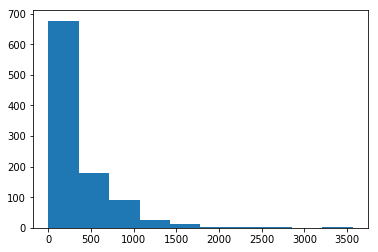

In [102]:
# Group engagement records by account_key 
engagement_by_account = group_data(paid_engagement_in_first_week, 'account_key')
# Sum of total minutes by account 
total_minutes_by_account = sum_grouped_items(engagement_by_account, 'total_minutes_visited')
# Print out summary statistics 
total_minutes = total_minutes_by_account.values()
describe_data(total_minutes)

The average number of minutes completed in the first week is around 307 minutes. 

#### Average number of lessons completed in the first week:


Mean: 1.64
Standard deviation: 3.0
Minimum: 0.0
Maximum: 36.0


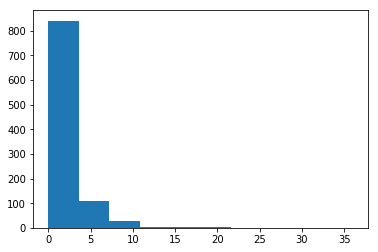

In [103]:
# Sum of total lessons by account 
lessons_completed_by_account = sum_grouped_items(engagement_by_account, 'lessons_completed')
describe_data(lessons_completed_by_account.values())

The average number of lessons completed in the first week is 1.64 lessons. Note this rounds down to 1.0 lessons on Udacity, since lessons can only be integer values. The large standard deviation is because students from different backgrounds are taking the course at different rates. 

#### Number of days student visited the classroom in a week

Let's find the number of days the student visited the classroom in a week, regardless of how many specific courses they visited that day. 

* change code in sum_grouped_items function 
* create a new field in the data calld "has_visited" which can be either a 1 or 0 where 1 = visited, 0 = not visited 

From method 2, we can add a new "has_visited" field where we can call the old sum_grouped_item function and take the sum over the "has_visited" values. We added "has_visited" field under the paid_enrollments table.

Mean: 2.87
Standard deviation: 2.26
Minimum: 0.0
Maximum: 7.0


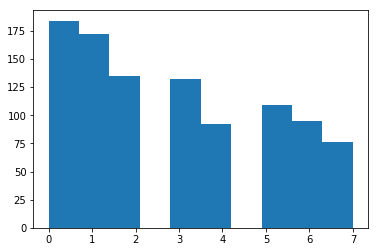

In [104]:
days_visited_by_account = sum_grouped_items(engagement_by_account, 'has_visited')
describe_data(days_visited_by_account.values())

The average total number of days a student visits the classroom is around 3 days a week. 

#### Finding the project completion rates 
We split the daily engagement table into students who pass the first project and students who do not. Udacity's first project was a "Subway Completion" project. In the project submission table, we check that the lesson_key matches the first project, and from the assigned_rating column, we check if student passed the project.

In [105]:
# Subway_project has two key values
subway_project_lesson_keys = ['746169184', '3176718735']

# First column of project completion table
paid_submissions[0]

{u'account_key': u'256',
 u'assigned_rating': u'UNGRADED',
 u'completion_date': datetime.datetime(2015, 1, 16, 0, 0),
 u'creation_date': datetime.datetime(2015, 1, 14, 0, 0),
 u'lesson_key': u'3176718735',
 u'processing_state': u'EVALUATED'}

In [106]:
# Find students who pass the first project 

pass_subway_project = set()

for submission in paid_submissions:
    project = submission['lesson_key']
    rating = submission['assigned_rating']
    if project in subway_project_lesson_keys and (rating == 'PASSED' or rating == 'DISTINCTION'):
        pass_subway_project.add(submission['account_key'])

print "Number of students who passed the first subject:", len(pass_subway_project)


Number of students who passed the first subject: 647


In [107]:
# Split data into passing vs non-passing projects 
passing_engagement = []
non_passing_engagement = []

for engagement_record in paid_engagement_in_first_week:
    # Check if student is one that passed the subway project 
    if engagement_record['account_key'] in pass_subway_project:
        passing_engagement.append(engagement_record)
    else:
        non_passing_engagement.append(engagement_record)
        
print "Students who passed:", len(passing_engagement)
print "Students who did not pass:", len(non_passing_engagement)

Students who passed: 4527
Students who did not pass: 2392


# Conclusions: 

Correlations between project completion rates and the following factors:
* 1) Minutes engaged
* 2) Lessons completed
* 3) Days visiting the classroom


#### 1) Minutes Engaged v.s. Project Completion 

* Passing students spend more time in the classroom (395 minutes/week) compared to non-passing students (143 minutes/week).
* The standard deviation for passing students is higher. Since the mean is higher, it is expected for the standard deviation to be higher as well. The more time students are spending, the easier it is to have more variations in the times.
* The maximum number of time spent in the classroom is higher for passing students.

Mean: 143.33
Standard deviation: 269.54
Minimum: 0.0
Maximum: 1768.52


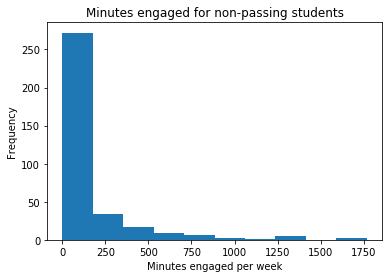

In [108]:
# Minutes engaged for non-passing students 
non_passing_engagement_by_account = group_data(non_passing_engagement, 'account_key')
non_passing_minutes = sum_grouped_items(non_passing_engagement_by_account, 'total_minutes_visited')
describe_data(non_passing_minutes.values())
plt.ylabel('Frequency')
plt.xlabel('Minutes engaged per week')
plt.title('Minutes engaged for non-passing students')

Mean: 394.59
Standard deviation: 448.5
Minimum: 0.0
Maximum: 3564.73


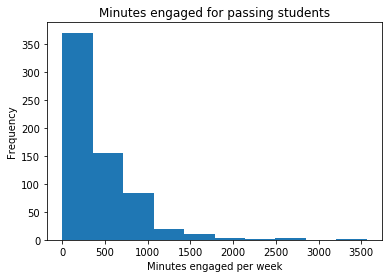

In [109]:
# Minutes engaged for passing students
passing_engagement_by_account = group_data(passing_engagement, 'account_key')
passing_minutes = sum_grouped_items(passing_engagement_by_account, 'total_minutes_visited')
describe_data(passing_minutes.values())
plt.ylabel('Frequency')
plt.xlabel('Minutes engaged per week')
plt.title('Minutes engaged for passing students')

#### 2) Lessons Completed v.s. Project Completion 

* Passing students complete more lessons 
* Average pace for passing student is 2 lessons/ week 
* Maximum is higher for students who pass 

Mean: 0.86
Standard deviation: 2.55
Minimum: 0.0
Maximum: 27.0


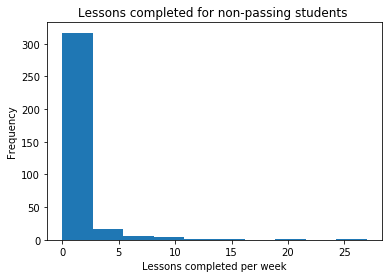

In [110]:
# Lessons completed for non-passing students 
non_passing_lessons = sum_grouped_items(non_passing_engagement_by_account, 'lessons_completed')
describe_data(non_passing_lessons.values())
plt.ylabel('Frequency')
plt.xlabel('Lessons completed per week')
plt.title('Lessons completed for non-passing students ')

Mean: 2.05
Standard deviation: 3.14
Minimum: 0.0
Maximum: 36.0


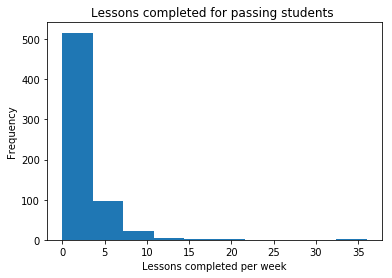

In [111]:
# Lessons completed for passing students 
passing_lessons = sum_grouped_items(passing_engagement_by_account, 'lessons_completed')
describe_data(passing_lessons.values())
plt.ylabel('Frequency')
plt.xlabel('Lessons completed per week')
plt.title('Lessons completed for passing students ')

#### 3) Days Visiting the Classroom v.s. Project Completion 

* For passing students, the number of days visited is higher 
* For both passing and non-passing students, the minimum and maximum days were the same 

Note: We changed the bins from 10 bins to 8 bins.

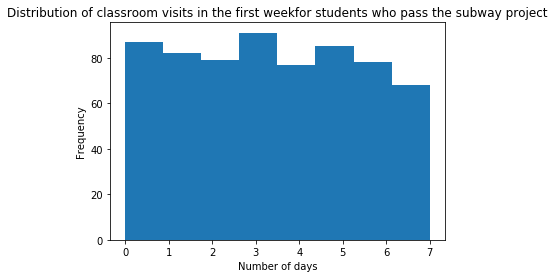

In [112]:
# Number of days visiting the classroom per week for non-passing students 
plt.hist(passing_visits.values(), bins = 8)
plt.xlabel('Number of days')
plt.ylabel('Frequency')
plt.title('Distribution of classroom visits in the first week'+ 
         'for students who pass the subway project')

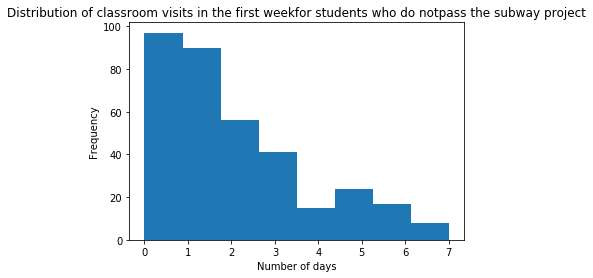

In [113]:
# Number of days visiting the classroom per week for passing students 
plt.hist(non_passing_visits.values(), bins=8)
plt.xlabel('Number of days')
plt.ylabel('Frequency')
plt.title('Distribution of classroom visits in the first week'+ 
         'for students who do notpass the subway project')

#### The strongest trend is the correlation between students who passed the first project and the number of minutes spent in the classroom. 

As correlation does not imply causation. There could be lurking variables that were not considered. Example of possible factors include the level of interest. People who are not interested in data science will be less interested to pass the course. Udacity should recommend other courses to them. Another possible factor would be a lack of background knowledge. People who lack a programming background can fall behind and be not pass the course. Udacity can recommend an intro programming course as a prereq. In order to truly find out if there is a causation between two variables, we will need to run an A/B test. To make predictions with the data, machine learning and statistical inferences need to be added. For instance, given this data, can we predict which students are more likely to pass their first project? 

#### Future Questions 
* How do we improve user retention?
* How do we improve user engagement? 
* How do we increase the number of students passing their projects?

